In [266]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import math
from sklearn.linear_model import Lasso
from sklearn.linear_model import Ridge
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVR
from sklearn.model_selection import train_test_split, TimeSeriesSplit
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from matplotlib import pyplot
import statsmodels.api as sm
from statsmodels.tsa.seasonal import seasonal_decompose
# import selenium
# from selenium import webdriver

In [4]:
# def get_link_urls(url,driver):
#     driver.get(url)
#     urls = []
#     for link in d.find_elements_by_tag_name('a'):
#         urls.append(link.get_attribute('href'))
#     return urls

# d = webdriver.Safari()
# urls = get_link_urls("http://localhost:8080", d)
# sub_urls = []
# for url in urls:
#     sub_urls.extend(get_link_urls(url))

In [2]:

df2 = pd.read_csv('c19.csv')
print(df2.head())
print(df2.shape)



               X             Y  ... Aged75to84  Aged85up
0 -856335.869598  7.036492e+06  ...        NaN       NaN
1 -856335.869598  7.036492e+06  ...        NaN       NaN
2 -856335.869598  7.036492e+06  ...        0.0       0.0
3 -856335.869598  7.036492e+06  ...        0.0       0.0
4 -856335.869598  7.036492e+06  ...        0.0       0.0

[5 rows x 41 columns]
(639, 41)


In [3]:
print(df2['Date'])

0      2020/02/29 00:00:00+00
1      2020/03/03 00:00:00+00
2      2020/03/04 00:00:00+00
3      2020/03/05 00:00:00+00
4      2020/03/06 00:00:00+00
                ...          
634    2021/11/26 00:00:00+00
635    2021/11/27 00:00:00+00
636    2021/11/28 00:00:00+00
637    2021/11/29 00:00:00+00
638    2021/11/30 00:00:00+00
Name: Date, Length: 639, dtype: object


Text(0, 0.5, 'Hospitalization numbers')

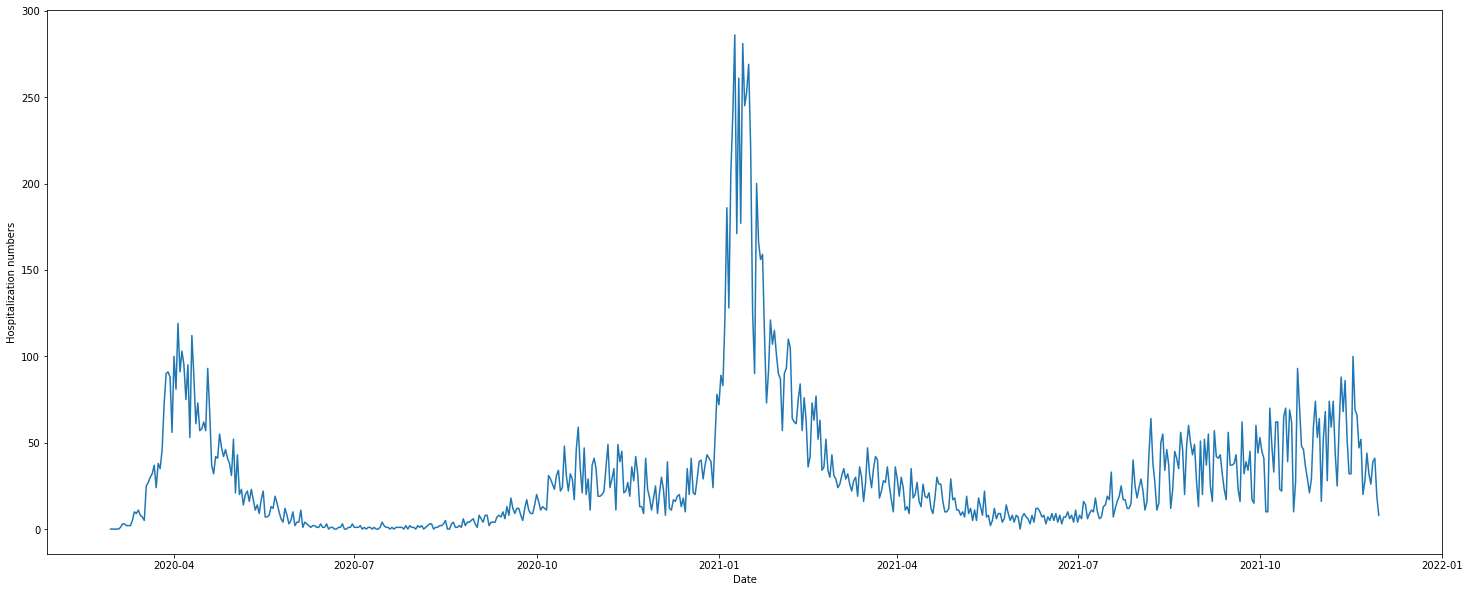

In [40]:


df2['Date'] = pd.to_datetime(df2['Date']).dt.date
df2['HCC'] = df2['HospitalisedCovidCases'].fillna(0)

# for index, row in df2.iterrows():
#     print(index, row['Date'], row['HCC'])

# d = df2['Date'][0]
prev_num = 0
df2['new_HCC'] = df2['HCC']
for index,row in df2.iterrows():
  df2.at[index, 'new_HCC'] = row['HCC'] - prev_num
  prev_num = row['HCC']

plt.plot(df2['Date'], df2['new_HCC'])
plt.xlabel('Date')
plt.ylabel('Hospitalization numbers')



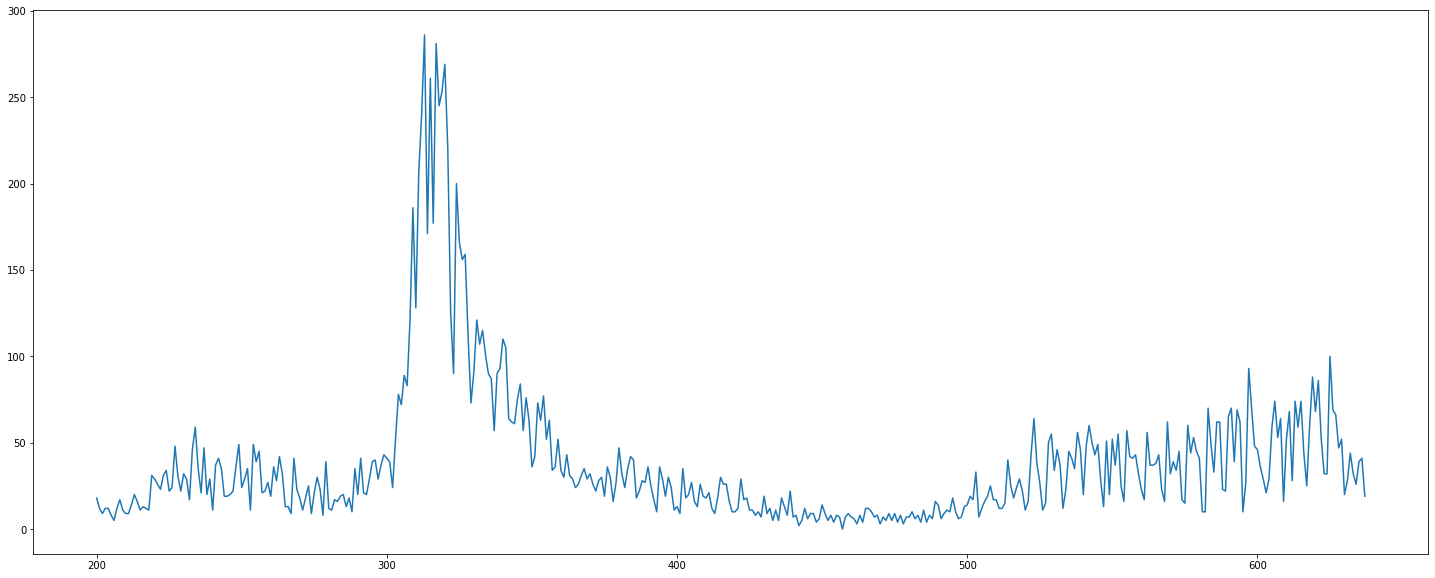

In [41]:
# i_range = []
# for i in range(293,400):
#   i_range.append(df2.Index[i, 'new_HCC'])

plt.plot(df2.iloc[200:638,42])
plt.show()

In [90]:
def choose_index_train(i1, i2, model_name, hyperparameter):  
  start=pd.to_datetime(df2['Date'][i1])
  print("Start: ", start)
  end=pd.to_datetime(df2['Date'][i2])
  print("End: ", end)
  t_full=pd.array(pd.DatetimeIndex(df2.iloc[i1:i2,2])).astype(np.int64)
  # print("Tfull: ", t_full)
  dt = t_full[2] - t_full[1] 
  print("Data sampling interval", dt)
  t = (t_full[i1+3]-t_full[i1+2])/60/60/24
  print(t)
  ss = pd.array(pd.Index(df2.iloc[i1:i2,42])).astype(np.int64) #42nd column is Hospitalization number
  og_ss = ss
  print(og_ss.size)
  plt.plot(df2.iloc[i1:i2, 2], ss, color='black')
  plt.show()

  stride = 1
  lag = 2 #determines the feature vector size
  dd = 1 #number of samples in a day 
  q = 1
  XX = og_ss[0:og_ss.size - q - lag * dd:stride]
  for i in range(1,lag): 
    X = og_ss[i*dd:og_ss.size - q - (lag-i)*dd:stride]
    XX = np.column_stack((XX,X))
    # print(XX.size) #will be size = lag * X_size
  yy = og_ss[lag*dd+q::stride] #size of XX before column stacking
  # print("SS:",ss.size)
  # print("yy:",yy.size)
  tt = t_full[lag*dd+q::stride]
    # print(tt.size)
  train, test = train_test_split(np.arange(0,yy.size),test_size=0.2)

  if(model_name == 'Lasso'):
    model = Lasso(fit_intercept=False, alpha=hyperparameter).fit(XX[train], yy[train]) 
  elif(model_name == 'Ridge'):
    model = Ridge(fit_intercept=False, alpha=hyperparameter).fit(XX[train], yy[train])
  elif(model_name == 'LR'):
    model = LogisticRegression(fit_intercept=True, penalty='l2').fit(XX[train], yy[train]) 
  elif(model_name == 'SVM'):
    model = SVR(C=50).fit(XX[train], yy[train]) 

  y_pred = model.predict(XX) 

  plt.rcParams["figure.figsize"] = (25,10)
  t_plot = plt.plot(t_full, og_ss, color='black', label='True values')
  # tt_dates = pd.to_datetime(tt).dt.Date
  p_plot = plt.plot(tt, y_pred, color='blue', label='Predicted values')
  plt.legend()
  plt.show()

  from sklearn.metrics import mean_squared_error
  mse = mean_squared_error(yy, y_pred)
  rmse = math.sqrt(mse)
  print("mse:", rmse)



Start:  2020-09-18 00:00:00
End:  2021-11-30 00:00:00
Data sampling interval 86400000000000
1000000000.0
438


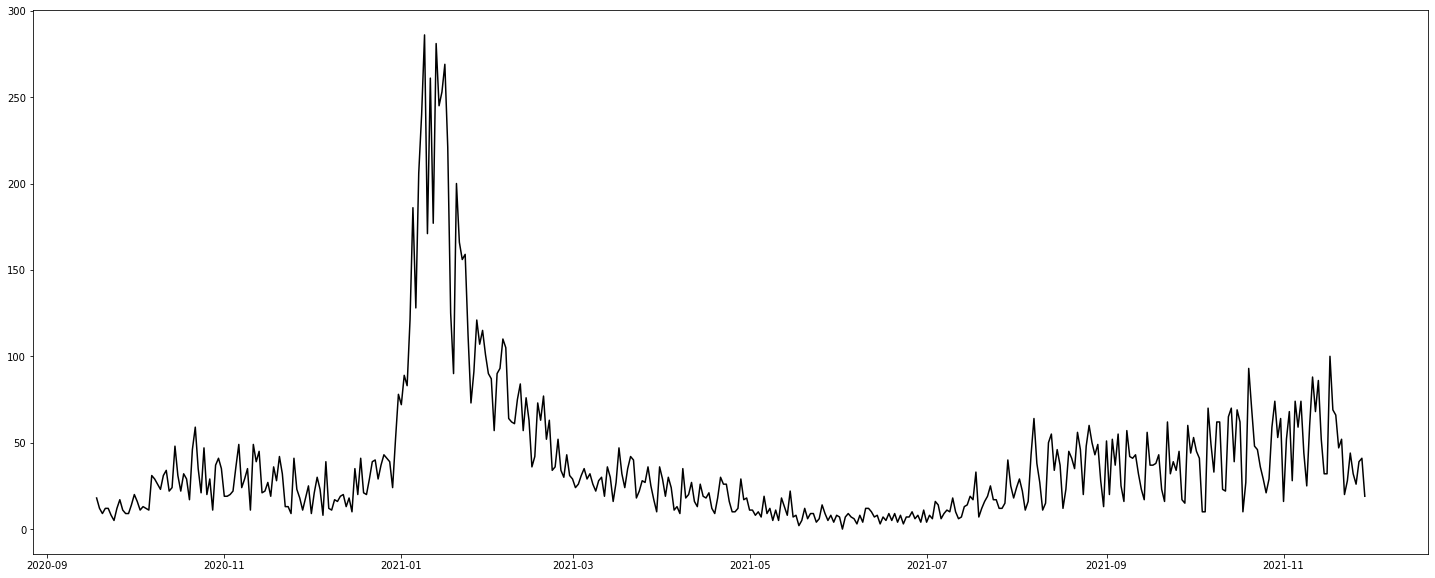

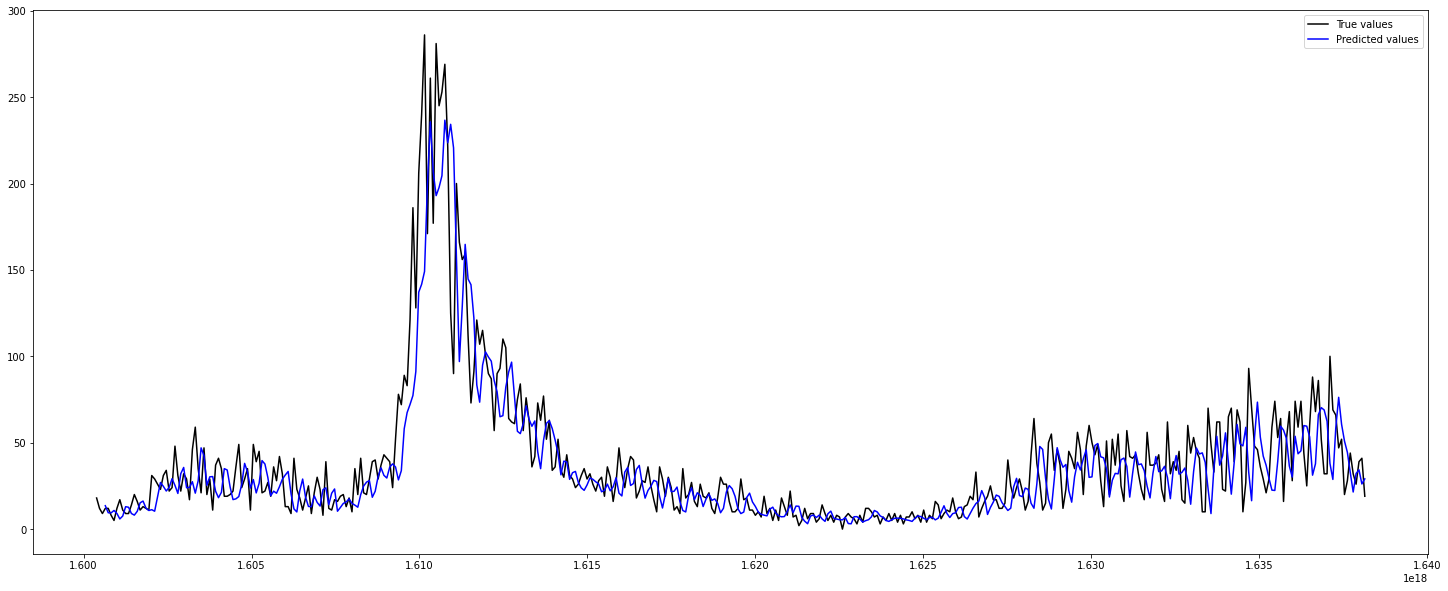

mse: 22.786907648385903


In [91]:
choose_index_train(200,638,'Ridge',0.1)

In [66]:
start = pd.to_datetime(df2['Date'][200])
print("Start: ", start)
end = pd.to_datetime(df2['Date'][638])
print("End: ", end)
t_full=pd.array(pd.DatetimeIndex(df2.iloc[200:638,2])).astype(np.int64)
# print("Tfull: ", t_full)
dt = t_full[2] - t_full[1] 
print("Data sampling interval", dt)

Start:  2020-09-18 00:00:00
End:  2021-11-30 00:00:00
Data sampling interval 86400000000000


1000000000.0
438


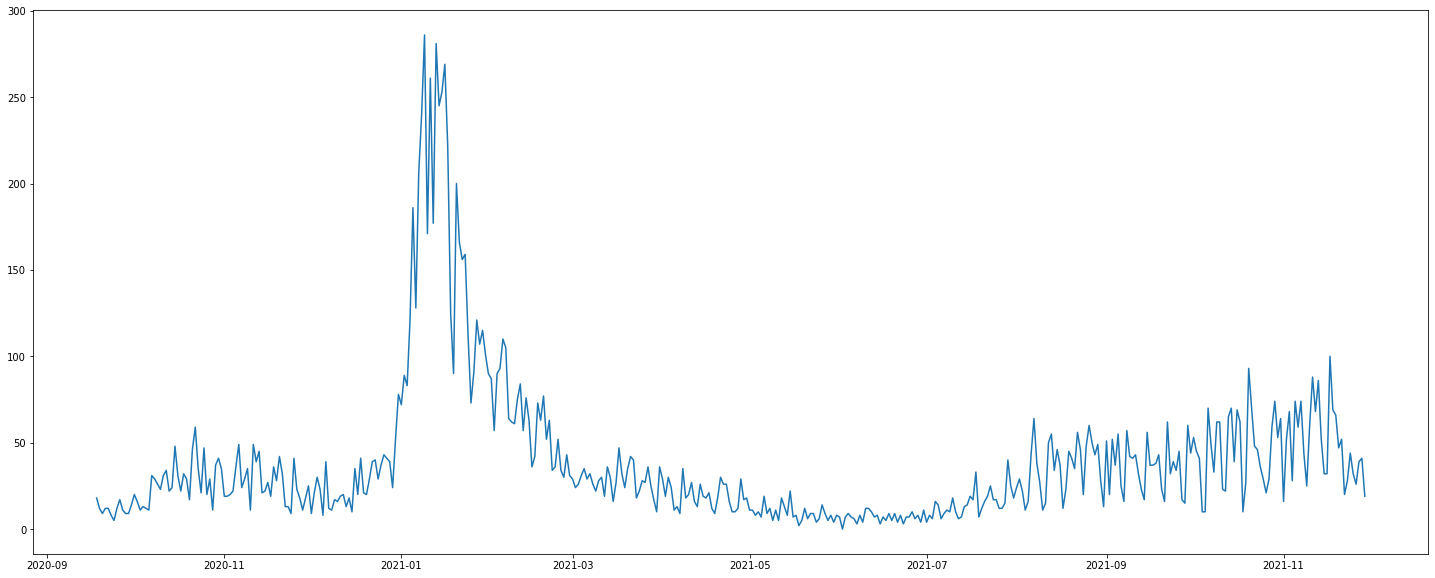

In [67]:
t = (t_full[33]-t_full[32])/60/60/24
print(t)
ss = pd.array(pd.Index(df2.iloc[200:638,42])).astype(np.int64)
og_ss = ss
print(og_ss.size)
plt.plot(df2.iloc[200:638, 2], ss)
plt.show()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:20: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_coordinate_descent.py:648: UserWarning: Coordinate descent with no regularization may lead to unexpected results and is discouraged.
  coef_, l1_reg, l2_reg, X, y, max_iter, tol, rng, random, positive
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 7.360e+04, tolerance: 1.100e+02 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  coef_, l1_reg, l2_reg, X, y, max_iter, tol, rng, random, posi

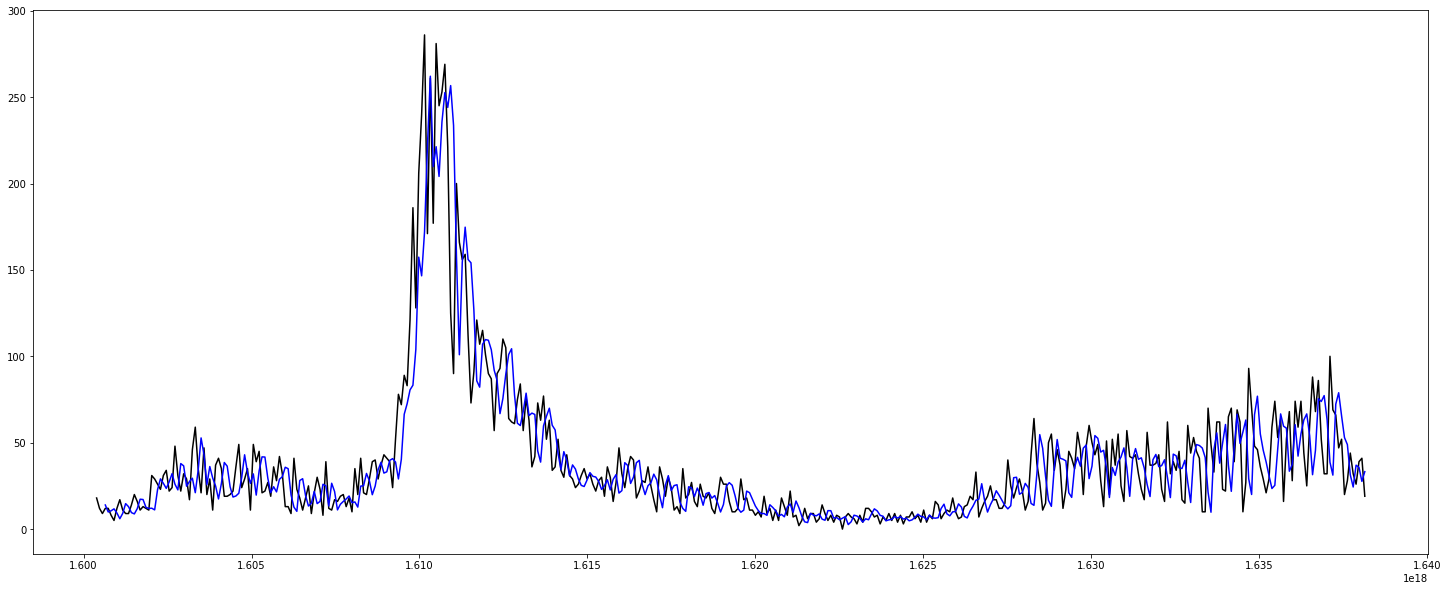

mse: 22.653439618538147


In [47]:
stride = 1
lag = 2 #determines the feature vector size
dd = 1 #number of samples in a day 
q = 1
XX = og_ss[0:og_ss.size - q - lag * dd:stride]
for i in range(1,lag): 
  X = og_ss[i*dd:og_ss.size - q - (lag-i)*dd:stride]
  XX = np.column_stack((XX,X))
  # print(XX.size) #will be size = lag * X_size
yy = og_ss[lag*dd+q::stride] #size of XX before column stacking
# print("SS:",ss.size)
# print("yy:",yy.size)
tt = t_full[lag*dd+q::stride]
  # print(tt.size)
from sklearn.model_selection import train_test_split 
train, test = train_test_split(np.arange(0,yy.size),test_size=0.2)

from sklearn.linear_model import Ridge 
from sklearn.linear_model import Lasso
model = Lasso(fit_intercept=False, alpha=0).fit(XX[train], yy[train]) 
  # print(model.intercept_, model.coef_)

y_pred = model.predict(XX) 

plt.rcParams["figure.figsize"] = (25,10)
plt.plot(t_full, og_ss, color='black')
plt.plot(tt, y_pred, color='blue')
plt.show()

from sklearn.metrics import mean_squared_error
mse = mean_squared_error(yy, y_pred)
rmse = math.sqrt(mse)
print("mse:", rmse)



In [227]:
def train_predict_Ridge(q_step, stride, lag, dd):
  # stride = stride
  # lag = lag #determines the feature vector size
  # dd = dd #number of samples in a day 
  q = 1
  ss = og_ss
  og_tt = t_full[lag*dd+q::stride]
  day_sec = 86400000000000
  for j in range(0,q_step*day_sec, day_sec):
    XX = ss[0:ss.size - q - lag * dd:stride]
    for i in range(1,lag): 
      X = ss[i*dd:ss.size - q - (lag-i)*dd:stride]
      XX = np.column_stack((XX,X))
    # print(XX.size) #will be size = lag * X_size
    yy = ss[lag*dd+q::stride] #size of XX before column stacking
    # print("SS:",ss.size)
    # print("yy:",yy.size)
    tt = t_full[lag*dd+q::stride]
    # print(tt.size)
    from sklearn.model_selection import train_test_split 
    train, test = train_test_split(np.arange(0,yy.size),test_size=0.2)

    from sklearn.linear_model import Ridge 
    model = Ridge(fit_intercept=True, alpha=10).fit(XX[train], yy[train]) 
    # print(model.intercept_, model.coef_)

    y_pred = model.predict(XX) 
    yp = y_pred[y_pred.size-1]
    ss = np.append(ss, yp)
    np.append(tt, tt[tt.size-1] + day_sec)
    # print("tt:",tt.size)

  # print("XX:" ,XX.size)

  y_pred_2 = model.predict(XX)
  # print("tfull:",t_full)
  tt_full2 = np.arange(t_full[t_full.size-1], t_full[t_full.size-1] + q_step*day_sec, day_sec)
  pred_num = tt_full2.size
  # print("ttfull2:",tt_full2)
  plt.rcParams["figure.figsize"] = (25,10)
  plt.plot(t_full, og_ss, color='black')
  t_full_dates2 = pd.to_datetime(tt_full2)
  t_full_extended = np.append(t_full, tt_full2)
  t_full_dates = pd.to_datetime(t_full_extended)
  # print(t_full_dates)
  plt.plot(tt_full2, y_pred_2[:q_step], color='blue')
  plt.xticks(t_full_extended, labels=t_full_dates, rotation=45)
  plt.locator_params(axis='x', nbins=10)
  plt.show()
  plt.plot(tt_full2, y_pred_2[:q_step], color='blue')
  plt.xticks(tt_full2, labels=t_full_dates2, rotation=45)
  plt.locator_params(axis='x', nbins=10)
  plt.show()

  from sklearn.metrics import mean_squared_error
  mse = mean_squared_error(yy, y_pred_2)
  rmse = math.sqrt(mse)
  return rmse




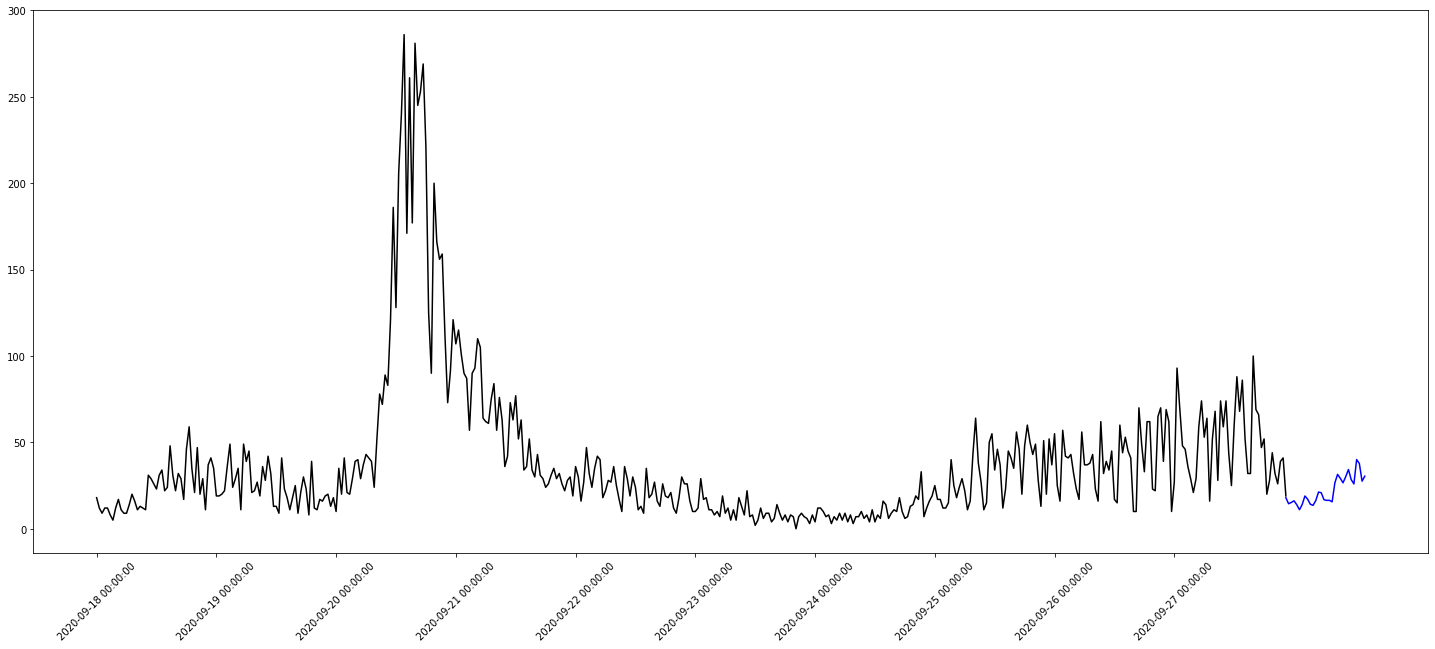

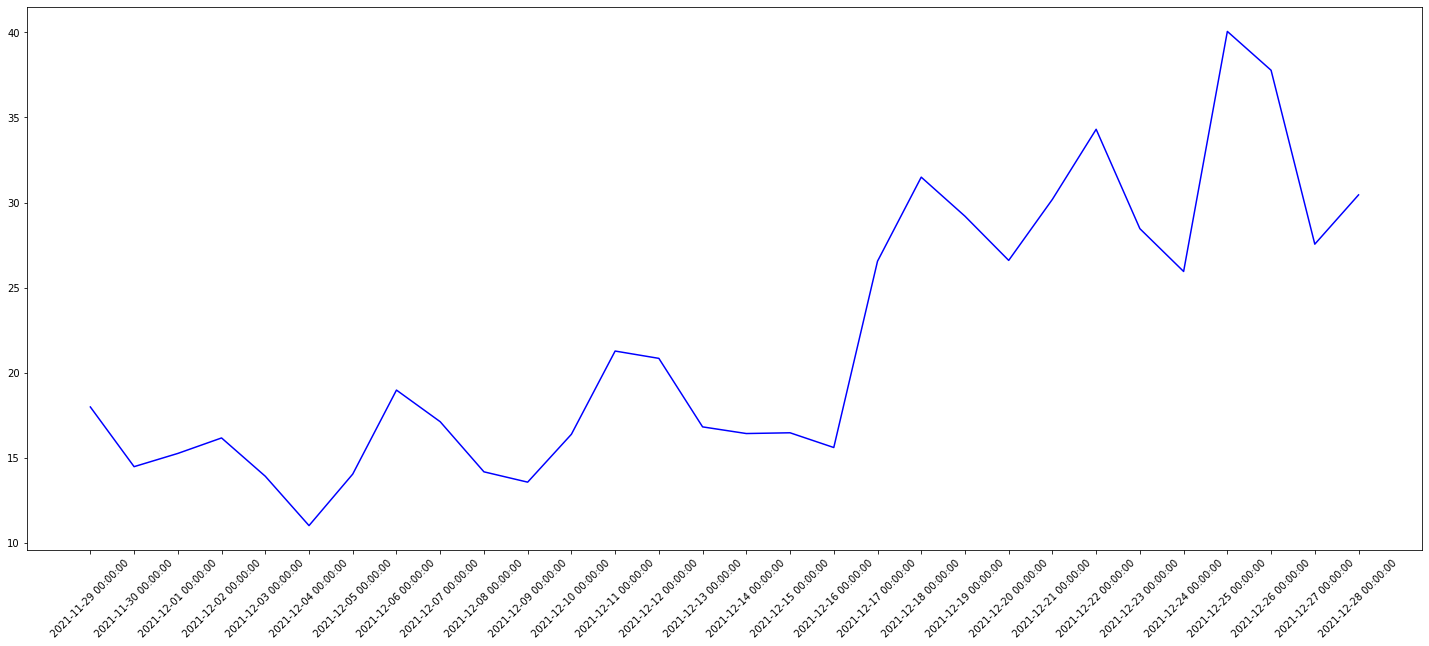

RMSE:  21.61266374419875


In [179]:
rmse_30 = train_predict_Ridge(30, 1, 2, 1)
print("RMSE: ", rmse_30)

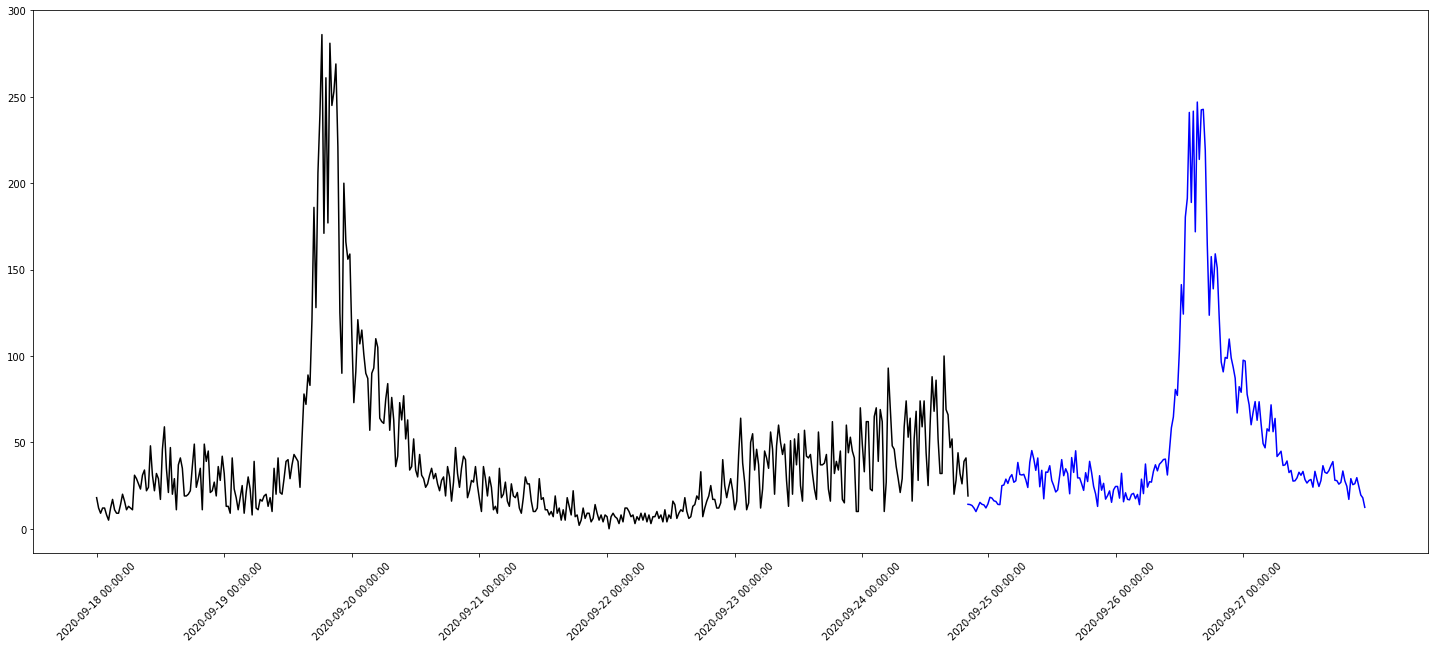

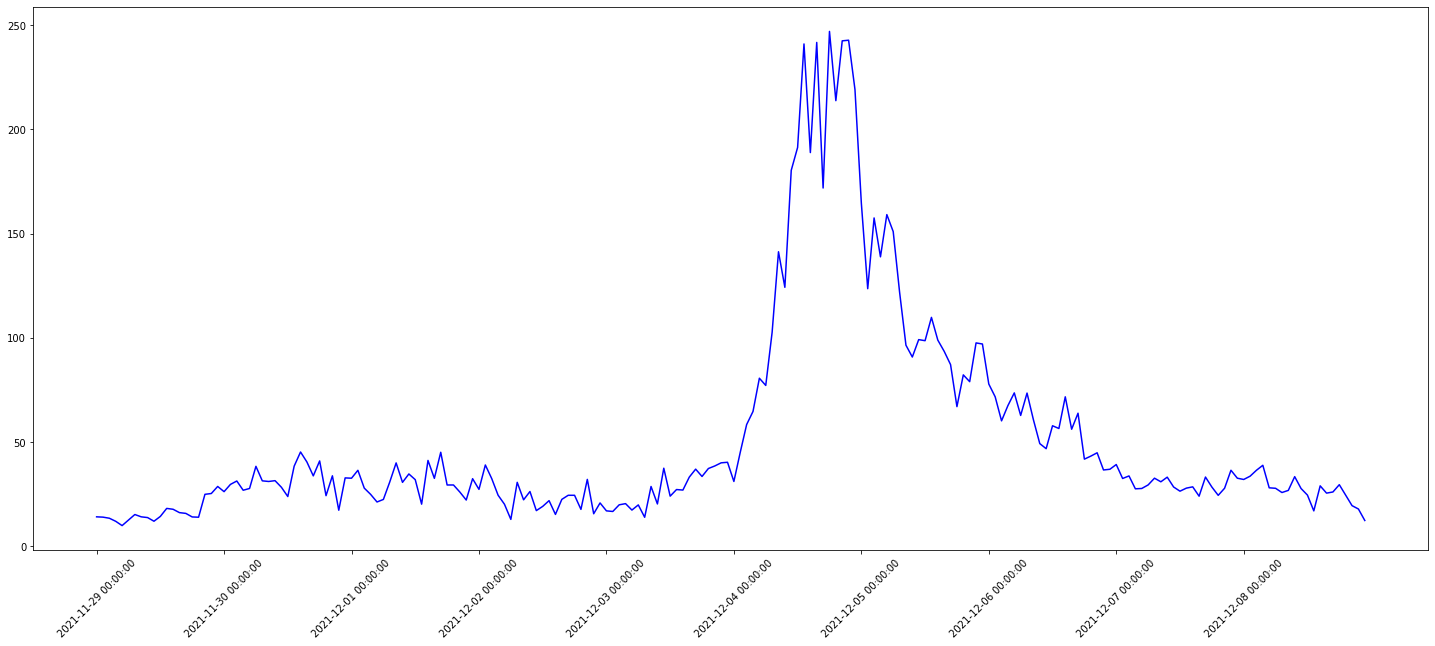

RMSE 100 days:  18.02972640097756


In [228]:
rmse_200 = train_predict_Ridge(200,1,3,1)
print("RMSE 100 days: ", rmse_200)

In [229]:
def train_predict_Lasso(q_step, stride, lag, dd):
  # stride = stride
  # lag = lag #determines the feature vector size
  # dd = dd #number of samples in a day 
  q = 1
  ss = og_ss
  og_tt = t_full[lag*dd+q::stride]
  day_sec = 86400000000000
  for j in range(0,q_step*day_sec, day_sec):
    XX = ss[0:ss.size - q - lag * dd:stride]
    for i in range(1,lag): 
      X = ss[i*dd:ss.size - q - (lag-i)*dd:stride]
      XX = np.column_stack((XX,X))
    # print(XX.size) #will be size = lag * X_size
    yy = ss[lag*dd+q::stride] #size of XX before column stacking
    # print("SS:",ss.size)
    # print("yy:",yy.size)
    tt = t_full[lag*dd+q::stride]
    # print(tt.size)
    from sklearn.model_selection import train_test_split 
    train, test = train_test_split(np.arange(0,yy.size),test_size=0.2)

    from sklearn.linear_model import Lasso 
    model = Lasso(fit_intercept=True, alpha=50).fit(XX[train], yy[train]) 
    # print(model.intercept_, model.coef_)

    y_pred = model.predict(XX) 
    yp = y_pred[y_pred.size-1]
    ss = np.append(ss, yp)
    np.append(tt, tt[tt.size-1] + day_sec)
    # print("tt:",tt.size)

  # print("XX:" ,XX.size)

  y_pred_2 = model.predict(XX)
  # print("tfull:",t_full)
  tt_full2 = np.arange(t_full[t_full.size-1], t_full[t_full.size-1] + q_step*day_sec, day_sec)
  pred_num = tt_full2.size
  # print("ttfull2:",tt_full2)
  plt.rcParams["figure.figsize"] = (25,10)
  plt.plot(t_full, og_ss, color='black')
  t_full_dates2 = pd.to_datetime(tt_full2)
  t_full_extended = np.append(t_full, tt_full2)
  t_full_dates = pd.to_datetime(t_full_extended)
  # print(t_full_dates)
  plt.plot(tt_full2, y_pred_2[:q_step], color='blue')
  plt.xticks(t_full_extended, labels=t_full_dates, rotation=45)
  plt.locator_params(axis='x', nbins=10)
  plt.show()
  plt.plot(tt_full2, y_pred_2[:q_step], color='blue')
  plt.xticks(tt_full2, labels=t_full_dates2, rotation=45)
  plt.locator_params(axis='x', nbins=10)
  plt.show()

  from sklearn.metrics import mean_squared_error
  mse = mean_squared_error(yy, y_pred_2)
  rmse = math.sqrt(mse)
  return rmse




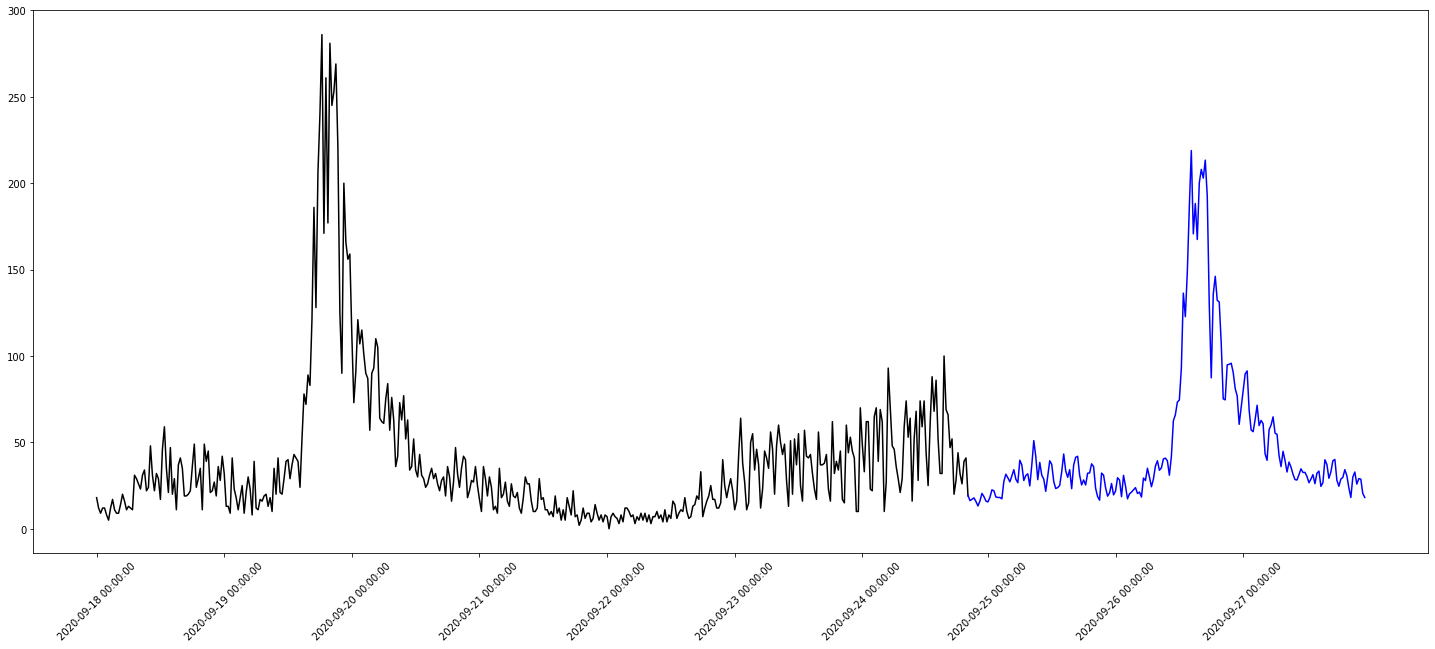

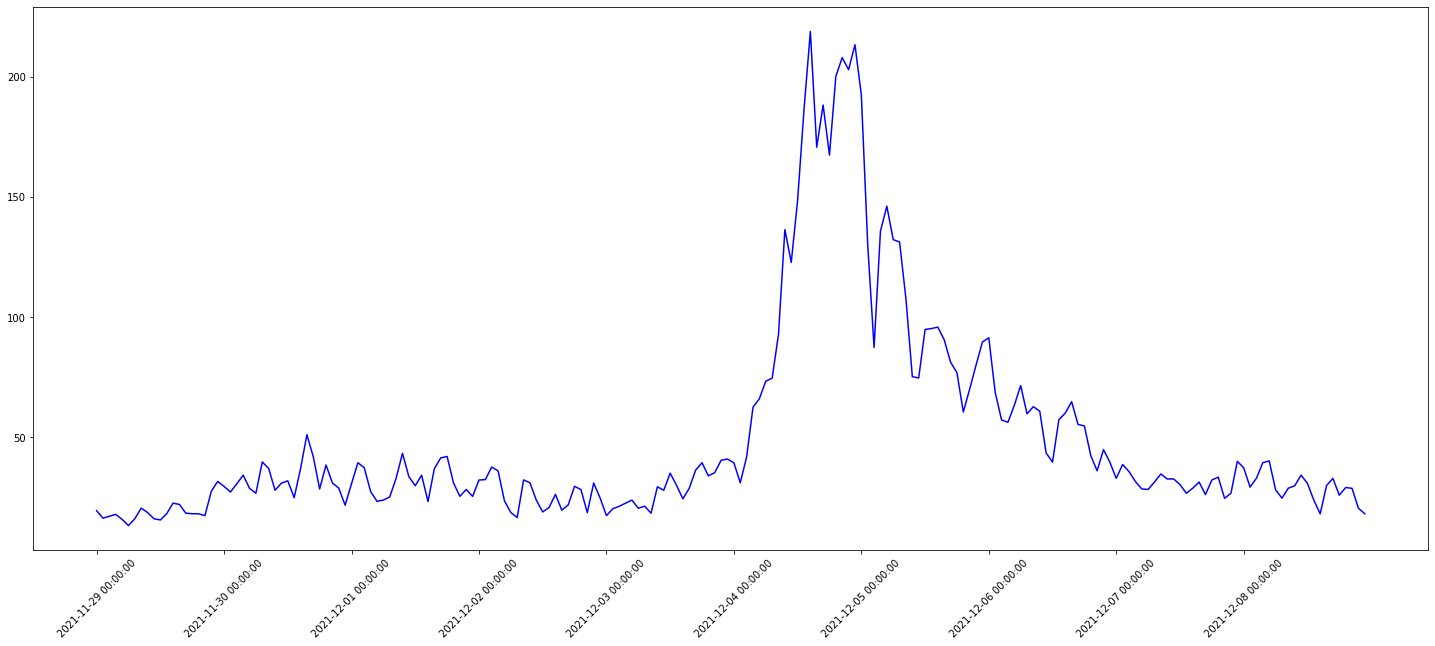

RMSE lasso 200: 18.83705086819591


In [230]:
rmse_lasso_200 = train_predict_Lasso(200, 1, 2, 1)
print("RMSE lasso 200:", rmse_lasso_200)

In [237]:
def train_predict_LR(q_step, stride, lag, dd):
  # stride = stride
  # lag = lag #determines the feature vector size
  # dd = dd #number of samples in a day 
  q = 1
  ss = og_ss
  og_tt = t_full[lag*dd+q::stride]
  day_sec = 86400000000000
  for j in range(0,q_step*day_sec, day_sec):
    XX = ss[0:ss.size - q - lag * dd:stride]
    for i in range(1,lag): 
      X = ss[i*dd:ss.size - q - (lag-i)*dd:stride]
      XX = np.column_stack((XX,X))
    # print(XX.size) #will be size = lag * X_size
    yy = ss[lag*dd+q::stride] #size of XX before column stacking
    # print("SS:",ss.size)
    # print("yy:",yy.size)
    tt = t_full[lag*dd+q::stride]
    # print(tt.size)
    from sklearn.model_selection import train_test_split 
    train, test = train_test_split(np.arange(0,yy.size),test_size=0.2)

    from sklearn.linear_model import LogisticRegression
    model = LogisticRegression(fit_intercept=True, penalty='l2',max_iter=1000).fit(XX[train], yy[train]) 
    # print(model.intercept_, model.coef_)

    y_pred = model.predict(XX) 
    yp = y_pred[y_pred.size-1]
    ss = np.append(ss, yp)
    np.append(tt, tt[tt.size-1] + day_sec)
    # print("tt:",tt.size)

  # print("XX:" ,XX.size)

  y_pred_2 = model.predict(XX)
  # print("tfull:",t_full)
  tt_full2 = np.arange(t_full[t_full.size-1], t_full[t_full.size-1] + q_step*day_sec, day_sec)
  pred_num = tt_full2.size
  # print("ttfull2:",tt_full2)
  plt.rcParams["figure.figsize"] = (25,10)
  plt.plot(t_full, og_ss, color='black')
  t_full_dates2 = pd.to_datetime(tt_full2)
  t_full_extended = np.append(t_full, tt_full2)
  t_full_dates = pd.to_datetime(t_full_extended)
  # print(t_full_dates)
  plt.plot(tt_full2, y_pred_2[:q_step], color='blue')
  plt.xticks(t_full_extended, labels=t_full_dates, rotation=45)
  plt.locator_params(axis='x', nbins=10)
  plt.show()
  plt.plot(tt_full2, y_pred_2[:q_step], color='blue')
  plt.xticks(tt_full2, labels=t_full_dates2, rotation=45)
  plt.locator_params(axis='x', nbins=10)
  plt.show()

  from sklearn.metrics import mean_squared_error
  mse = mean_squared_error(yy, y_pred_2)
  rmse = math.sqrt(mse)
  return rmse




/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression


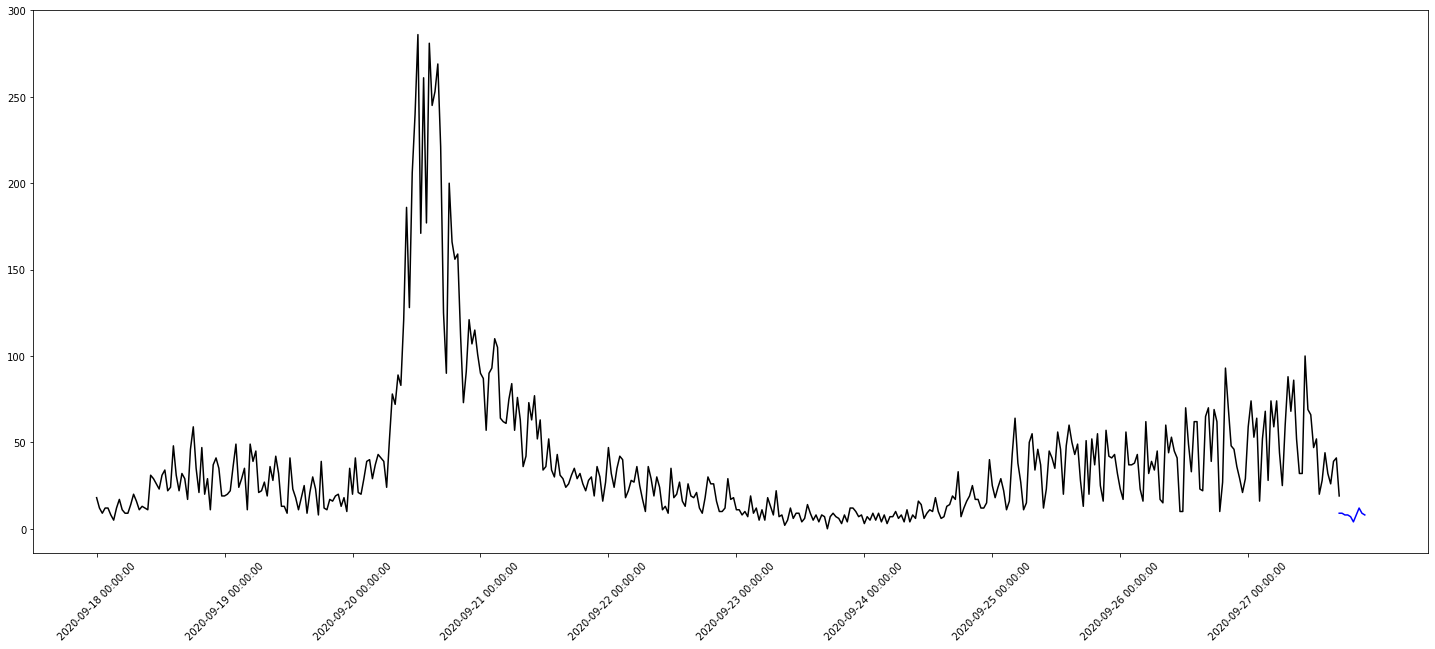

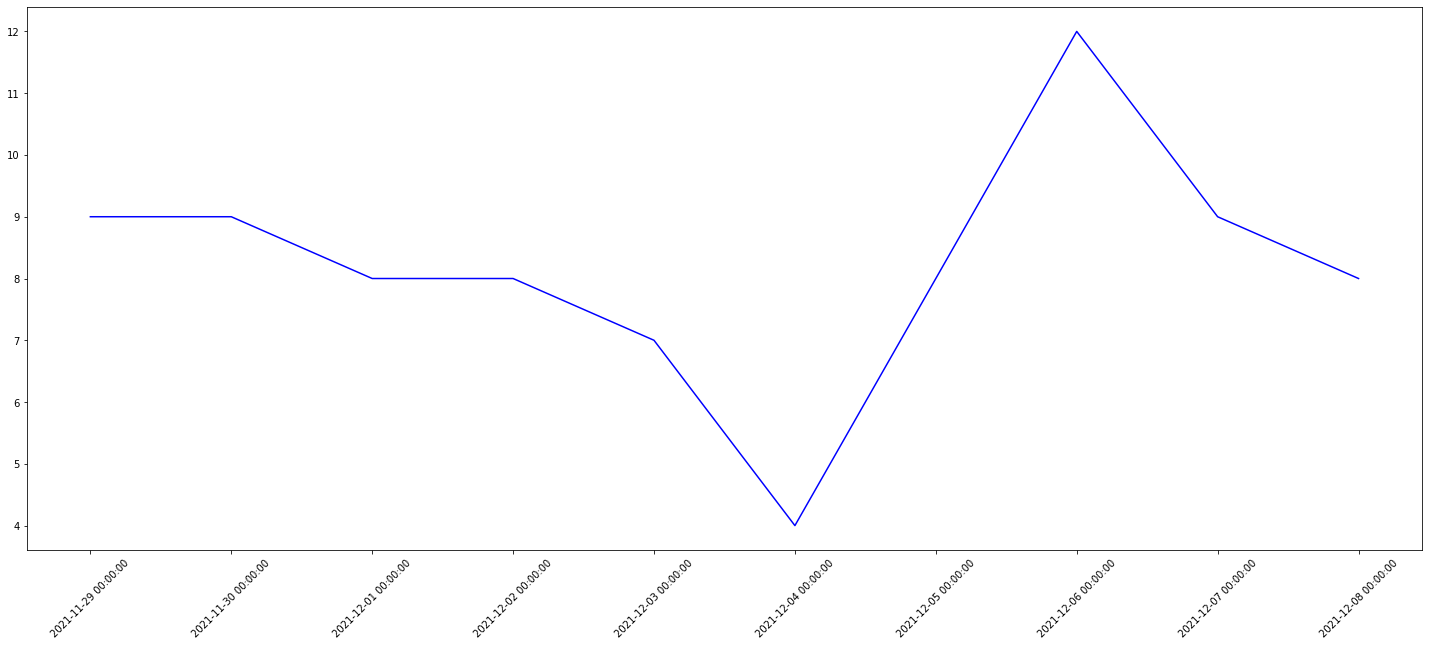

rmse lr 200: 41.82934010588374


In [238]:
rmse_lr_10 = train_predict_LR(10, 1, 2, 1)
print("rmse lr 200:", rmse_lr_200)

In [274]:
# def train_predict_SVR(q_step, stride, lag, dd):
#   # stride = stride
#   # lag = lag #determines the feature vector size
#   # dd = dd #number of samples in a day 
#   q = 1
#   ss = og_ss
#   og_tt = t_full[lag*dd+q::stride]
#   day_sec = t_full[2] - t_full[1]
#   for j in range(0,q_step*day_sec, day_sec):
#     XX = ss[0:ss.size - q - lag * dd:stride]
#     for i in range(1,lag): 
#       X = ss[i*dd:ss.size - q - (lag-i)*dd:stride]
#       XX = np.column_stack((XX,X))
#     # print(XX.size) #will be size = lag * X_size
#     yy = ss[lag*dd+q::stride] #size of XX before column stacking
#     # print("SS:",ss.size)
#     # print("yy:",yy.size)
#     tt = t_full[lag*dd+q::stride]
#     # print(tt.size)
#     from sklearn.model_selection import train_test_split 
#     train, test = train_test_split(np.arange(0,yy.size),test_size=0.2)

#     from sklearn.linear_model import LogisticRegression
#     model = SVR(C=50)
#     model.fit(XX[train], yy[train]) 
#     # print(model.intercept_, model.coef_)

#     y_pred = model.predict(XX) 
#     yp = y_pred[y_pred.size-1]
#     ss = np.append(ss, yp)
#     np.append(tt, tt[tt.size-1] + day_sec)
#     # print("tt:",tt.size)

#   # print("XX:" ,XX.size)

#   y_pred_2 = model.predict(XX)
#   # print("tfull:",t_full)
#   tt_full2 = np.arange(t_full[t_full.size-1], t_full[t_full.size-1] + q_step*day_sec, day_sec)
#   pred_num = tt_full2.size
#   # print("ttfull2:",tt_full2)
#   plt.rcParams["figure.figsize"] = (25,10)
#   plt.plot(t_full, og_ss, color='black')
#   t_full_dates2 = pd.to_datetime(tt_full2)
#   t_full_extended = np.append(t_full, tt_full2)
#   t_full_dates = pd.to_datetime(t_full_extended)
#   # print(t_full_dates)
#   plt.plot(tt_full2, y_pred_2[:q_step], color='blue')
#   plt.xticks(t_full_extended, labels=t_full_dates, rotation=45)
#   plt.locator_params(axis='x', nbins=10)
#   plt.show()
#   plt.plot(tt_full2, y_pred_2[:q_step], color='blue')
#   plt.xticks(tt_full2, labels=t_full_dates2, rotation=45)
#   plt.locator_params(axis='x', nbins=10)
#   plt.show()

#   from sklearn.metrics import mean_squared_error
#   mse = mean_squared_error(yy, y_pred_2)
#   rmse = math.sqrt(mse)
#   return rmse




In [273]:
# rmse_svr = train_predict_SVC(200, 1, 2, 1)
# print("RMSE svc 200: ", rmse_svr)

Start:  2020-09-18 00:00:00
End:  2021-11-30 00:00:00
Data sampling interval 86400000000000
1000000000.0
438
[5353.3441506791305, 184.31116299941758, 40.19509401553648, 299.8002689550102, 758.4208039644515]
[0.014401597552577743, 5.3871883789343554e-05, 0.0001726814749945111, 9.449770428898073e-05, 0.00020251513174019474]


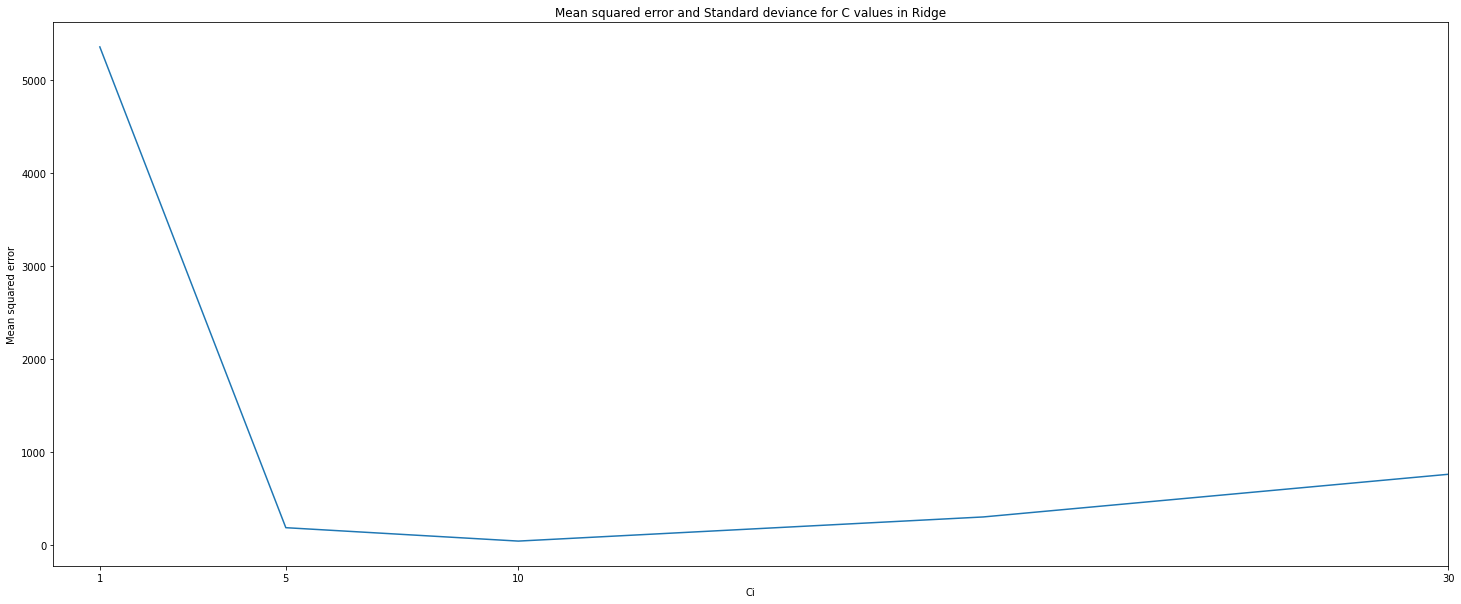

Ridge best C:  10  , Ridge rmse:  6.339960095736919


In [262]:
def Ridge_Performance(i1, i2):
  start=pd.to_datetime(df2['Date'][i1])
  print("Start: ", start)
  end=pd.to_datetime(df2['Date'][i2])
  print("End: ", end)
  t_full=pd.array(pd.DatetimeIndex(df2.iloc[i1:i2,2])).astype(np.int64)
  # print("Tfull: ", t_full)
  dt = t_full[2] - t_full[1] 
  print("Data sampling interval", dt)
  t = (t_full[i1+3]-t_full[i1+2])/60/60/24
  print(t)
  ss = pd.array(pd.Index(df2.iloc[i1:i2,42])).astype(np.int64) #42nd column is Hospitalization number
  og_ss = ss
  print(og_ss.size)

  stride = 1
  lag = 2 #determines the feature vector size
  dd = 1 #number of samples in a day 
  q = 1
  XX = og_ss[0:og_ss.size - q - lag * dd:stride]
  for i in range(1,lag): 
    X = og_ss[i*dd:og_ss.size - q - (lag-i)*dd:stride]
    XX = np.column_stack((XX,X))
    # print(XX.size) #will be size = lag * X_size
  yy = og_ss[lag*dd+q::stride] #size of XX before column stacking
  # print("SS:",ss.size)
  # print("yy:",yy.size)
  tt = t_full[lag*dd+q::stride]

  tscv = TimeSeriesSplit()
  TimeSeriesSplit(gap=0, max_train_size=None, n_splits=5, test_size=None)
  mean_error = []
  std_error = []
  C = [1, 5, 10, 20, 30]
  for train_index, test_index in tscv.split(XX):
    temp = []
    temp2 =[]
    for Ci in C:
      model = Ridge(fit_intercept=True, alpha=Ci)
      model.fit(XX[train_index], yy[train_index])
      y_pred = model.predict(XX[test_index])
      temp.append(mean_squared_error(yy[test_index], y_pred))
      temp2.append(mean_absolute_error(yy[test_index], y_pred))
    mean_error.append(np.array(temp).mean())
    std_error.append(np.array(temp2).std())
  plt.xlim((0, 30))
  plt.errorbar(C, mean_error, yerr=std_error)
  plt.xlabel('Ci')
  print(mean_error)
  print(std_error)
  plt.xticks([1, 5, 10, 30])
  plt.ylabel('Mean squared error')
  plt.title('Mean squared error and Standard deviance for C values in Ridge')

  plt.show()
  return (C[mean_error.index(min(mean_error))], min(mean_error))

ridge_best_c, ridge_mse = Ridge_Performance(200,638)
print("Ridge best C: ", ridge_best_c, " , Ridge rmse: ", math.sqrt(ridge_mse))

Start:  2020-09-18 00:00:00
End:  2021-11-30 00:00:00
Data sampling interval 86400000000000
1000000000.0
438
[8809.648863195773, 187.56077687896067, 47.86097355137524, 294.65630647100744, 742.9910345146875]
[9.963815012647881, 0.102397950091695, 0.5031543657619496, 0.08769302457219776, 0.22914712107977095]


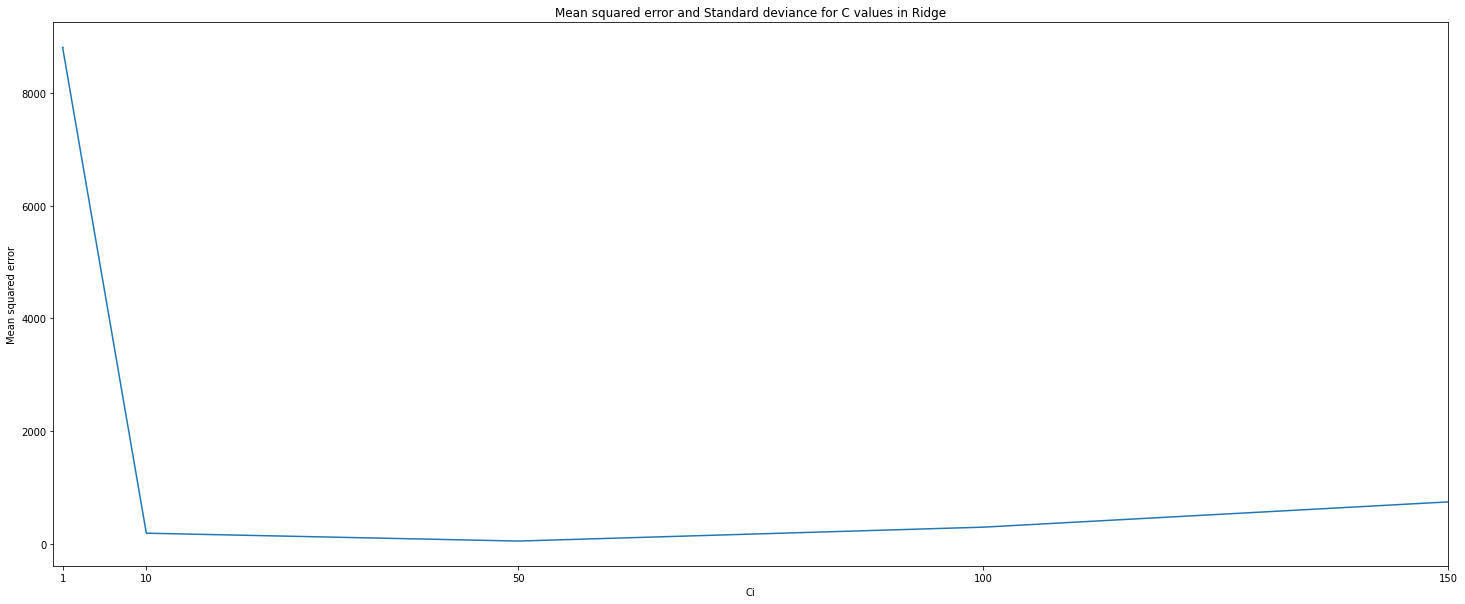

Lasso best C:  50  , Lasso rmse:  6.918162584919152


In [130]:
def Lasso_Performance(i1, i2):
  start=pd.to_datetime(df2['Date'][i1])
  print("Start: ", start)
  end=pd.to_datetime(df2['Date'][i2])
  print("End: ", end)
  t_full=pd.array(pd.DatetimeIndex(df2.iloc[i1:i2,2])).astype(np.int64)
  # print("Tfull: ", t_full)
  dt = t_full[2] - t_full[1] 
  print("Data sampling interval", dt)
  t = (t_full[i1+3]-t_full[i1+2])/60/60/24
  print(t)
  ss = pd.array(pd.Index(df2.iloc[i1:i2,42])).astype(np.int64) #42nd column is Hospitalization number
  og_ss = ss
  print(og_ss.size)

  stride = 1
  lag = 2 #determines the feature vector size
  dd = 1 #number of samples in a day 
  q = 1
  XX = og_ss[0:og_ss.size - q - lag * dd:stride]
  for i in range(1,lag): 
    X = og_ss[i*dd:og_ss.size - q - (lag-i)*dd:stride]
    XX = np.column_stack((XX,X))
    # print(XX.size) #will be size = lag * X_size
  yy = og_ss[lag*dd+q::stride] #size of XX before column stacking
  # print("SS:",ss.size)
  # print("yy:",yy.size)
  tt = t_full[lag*dd+q::stride]

  tscv = TimeSeriesSplit()
  TimeSeriesSplit(gap=0, max_train_size=None, n_splits=5, test_size=None)
  mean_error = []
  std_error = []
  C = [1, 10, 50, 100, 150]
  for train_index, test_index in tscv.split(XX):
    temp = []
    temp2 =[]
    for Ci in C:
      model = Lasso(fit_intercept=True, alpha=Ci)
      model.fit(XX[train_index], yy[train_index])
      y_pred = model.predict(XX[test_index])
      temp.append(mean_squared_error(yy[test_index], y_pred))
      temp2.append(mean_absolute_error(yy[test_index], y_pred))
    mean_error.append(np.array(temp).mean())
    std_error.append(np.array(temp2).std())
  plt.xlim((0, 150))
  plt.errorbar(C, mean_error, yerr=std_error)
  plt.xlabel('Ci')
  print(mean_error)
  print(std_error)
  plt.xticks(C)
  plt.ylabel('Mean squared error')
  plt.title('Mean squared error and Standard deviance for C values in Ridge')

  plt.show()
  return (C[mean_error.index(min(mean_error))], min(mean_error))
  

(lasso_best_c, lasso_mse) = Lasso_Performance(200,638)
print("Lasso best C: ", lasso_best_c, " , Lasso rmse: ", math.sqrt(lasso_mse))

Start:  2020-09-18 00:00:00
End:  2021-11-30 00:00:00
Data sampling interval 86400000000000
1000000000.0
438
[10337.342683453548, 178.96214855135162, 162.39632856977585, 273.8185918644918, 701.8711186180366]
[362.67436165137593, 17.931563423697366, 70.2205246102275, 18.415150005480296, 31.26541686443803]


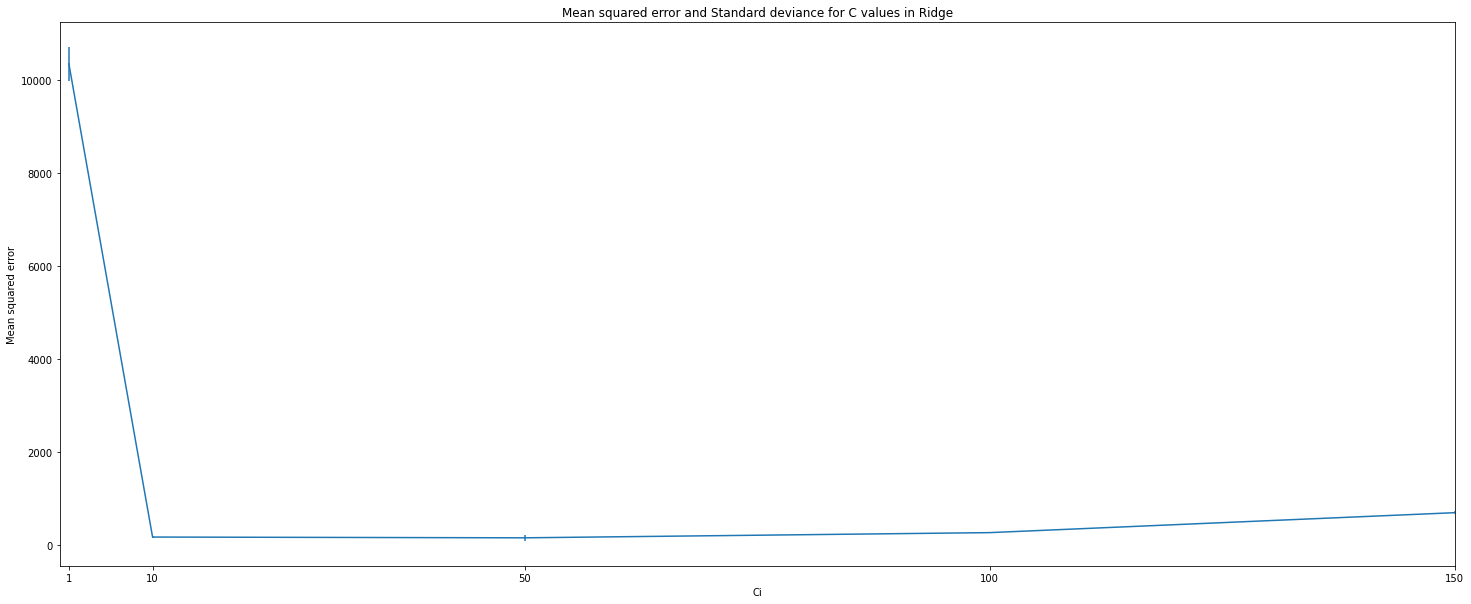

SVR best C:  50  , SVR rmse:  12.743481807174044


In [270]:
def SVR_Performance(i1, i2):
  start=pd.to_datetime(df2['Date'][i1])
  print("Start: ", start)
  end=pd.to_datetime(df2['Date'][i2])
  print("End: ", end)
  t_full=pd.array(pd.DatetimeIndex(df2.iloc[i1:i2,2])).astype(np.int64)
  # print("Tfull: ", t_full)
  dt = t_full[2] - t_full[1] 
  print("Data sampling interval", dt)
  t = (t_full[i1+3]-t_full[i1+2])/60/60/24
  print(t)
  ss = pd.array(pd.Index(df2.iloc[i1:i2,42])).astype(np.int64) #42nd column is Hospitalization number
  og_ss = ss
  print(og_ss.size)

  stride = 1
  lag = 2 #determines the feature vector size
  dd = 1 #number of samples in a day 
  q = 1
  XX = og_ss[0:og_ss.size - q - lag * dd:stride]
  for i in range(1,lag): 
    X = og_ss[i*dd:og_ss.size - q - (lag-i)*dd:stride]
    XX = np.column_stack((XX,X))
    # print(XX.size) #will be size = lag * X_size
  yy = og_ss[lag*dd+q::stride] #size of XX before column stacking
  # print("SS:",ss.size)
  # print("yy:",yy.size)
  tt = t_full[lag*dd+q::stride]

  tscv = TimeSeriesSplit()
  TimeSeriesSplit(gap=0, max_train_size=None, n_splits=5, test_size=None)
  mean_error = []
  std_error = []
  C = [1, 10, 50, 100, 150]
  for train_index, test_index in tscv.split(XX):
    temp = []
    temp2 =[]
    for Ci in C:
      model = SVR(C=Ci)
      model.fit(XX[train_index], yy[train_index])
      y_pred = model.predict(XX[test_index])
      temp.append(mean_squared_error(yy[test_index], y_pred))
      temp2.append(mean_absolute_error(yy[test_index], y_pred))
    mean_error.append(np.array(temp).mean())
    std_error.append(np.array(temp).std())
  plt.xlim((0, 150))
  plt.errorbar(C, mean_error, yerr=std_error)
  plt.xlabel('Ci')
  print(mean_error)
  print(std_error)
  plt.xticks(C)
  plt.ylabel('Mean squared error')
  plt.title('Mean squared error and Standard deviance for C values in Ridge')

  plt.show()
  return (C[mean_error.index(min(mean_error))], min(mean_error))
  

(svm_best_c, svr_mse) = SVR_Performance(200,638)
print("SVR best C: ", svm_best_c, " , SVR rmse: ", math.sqrt(svr_mse))

Start:  2020-09-18 00:00:00
End:  2021-11-30 00:00:00
Data sampling interval 86400000000000
1000000000.0
438


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of f AND g EVALUATIONS EXCEEDS LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of f AND g EVALUATIONS EXCEEDS LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#lo

[9543.95, 358.21388888888885, 39.99722222222222, 383.425, 950.9194444444445]
[1283.8167959169234, 44.46486562097493, 3.931918687854727, 47.9771523233896, 112.50022647439478]


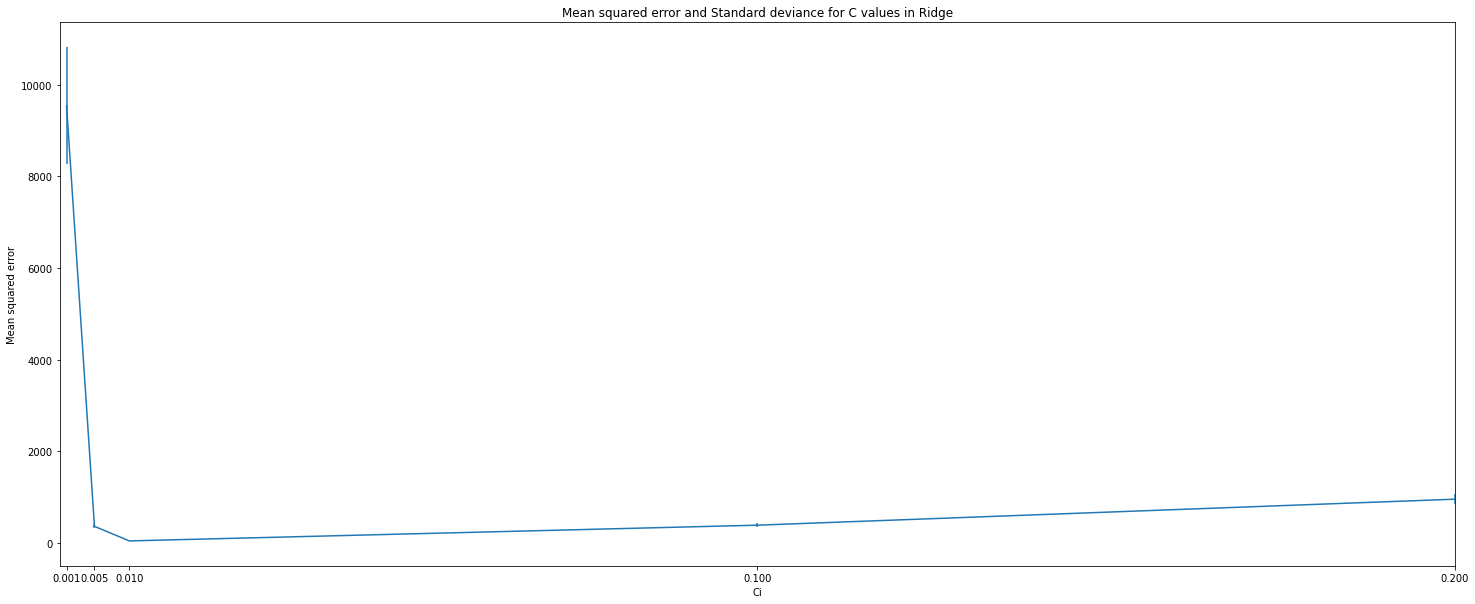

LR best C:  0.01  , LR rmse:  6.324335713908791


In [264]:
def LR_Performance(i1, i2):
  start=pd.to_datetime(df2['Date'][i1])
  print("Start: ", start)
  end=pd.to_datetime(df2['Date'][i2])
  print("End: ", end)
  t_full=pd.array(pd.DatetimeIndex(df2.iloc[i1:i2,2])).astype(np.int64)
  # print("Tfull: ", t_full)
  dt = t_full[2] - t_full[1] 
  print("Data sampling interval", dt)
  t = (t_full[i1+3]-t_full[i1+2])/60/60/24
  print(t)
  ss = pd.array(pd.Index(df2.iloc[i1:i2,42])).astype(np.int64) #42nd column is Hospitalization number
  og_ss = ss
  print(og_ss.size)

  stride = 1
  lag = 2 #determines the feature vector size
  dd = 1 #number of samples in a day 
  q = 1
  XX = og_ss[0:og_ss.size - q - lag * dd:stride]
  for i in range(1,lag): 
    X = og_ss[i*dd:og_ss.size - q - (lag-i)*dd:stride]
    XX = np.column_stack((XX,X))
    # print(XX.size) #will be size = lag * X_size
  yy = og_ss[lag*dd+q::stride] #size of XX before column stacking
  # print("SS:",ss.size)
  # print("yy:",yy.size)
  tt = t_full[lag*dd+q::stride]

  tscv = TimeSeriesSplit()
  TimeSeriesSplit(gap=0, max_train_size=None, n_splits=5, test_size=None)
  mean_error = []
  std_error = []
  C = [0.001, 0.005, 0.01, 0.1, 0.2]
  for train_index, test_index in tscv.split(XX):
    temp = []
    temp2 =[]
    for Ci in C:
      model = LogisticRegression(fit_intercept=True, penalty='l2', max_iter=100000, C=Ci)
      model.fit(XX[train_index], yy[train_index])
      y_pred = model.predict(XX[test_index])
      temp.append(mean_squared_error(yy[test_index], y_pred))
      temp2.append(mean_absolute_error(yy[test_index], y_pred))
    mean_error.append(np.array(temp).mean())
    std_error.append(np.array(temp).std())
  plt.xlim((0, 0.2))
  plt.errorbar(C, mean_error, yerr=std_error)
  plt.xlabel('Ci')
  print(mean_error)
  print(std_error)
  plt.xticks(C)
  plt.ylabel('Mean squared error')
  plt.title('Mean squared error and Standard deviance for C values in Ridge')

  plt.show()
  return (C[mean_error.index(min(mean_error))], min(mean_error))
  

(lr_best_c,lr_mse) = LR_Performance(200,638)
print("LR best C: ", lr_best_c, " , LR rmse: ", math.sqrt(lr_mse))

In [265]:
def dummy_Classifier(i1, i2):
  start=pd.to_datetime(df2['Date'][i1])
  print("Start: ", start)
  end=pd.to_datetime(df2['Date'][i2])
  print("End: ", end)
  t_full=pd.array(pd.DatetimeIndex(df2.iloc[i1:i2,2])).astype(np.int64)
  # print("Tfull: ", t_full)
  dt = t_full[2] - t_full[1] 
  print("Data sampling interval", dt)
  t = (t_full[i1+3]-t_full[i1+2])/60/60/24
  print(t)
  ss = pd.array(pd.Index(df2.iloc[i1:i2,42])).astype(np.int64) #42nd column is Hospitalization number
  og_ss = ss
  print(og_ss.size)

  from sklearn.dummy import DummyRegressor
  model = DummyRegressor().fit(XX[train], yy[train])
    # print(model.intercept_, model.coef_)

  y_pred = model.predict(XX)
    # print("tt:",tt.size)
    # print("XX:" ,XX.size)

  # print("tfull:",t_full)
  
  # print("ttfull2:",tt_full2)
  # plt.rcParams["figure.figsize"] = (25,10)
  # plt.plot(t_full, og_ss, color='black')
  # t_full_dates = pd.to_datetime(tt_full2)
  # # print(t_full_dates)
  # plt.plot(tt_full2, y_pred[:q_step], color='blue')
  # plt.xticks(tt_full2, labels=t_full_dates)
  # plt.show()
  # plt.plot(tt_full2, y_pred_2[:q_step], color='blue')
  # plt.xticks(tt_full2, labels=t_full_dates)
  # plt.show()

  from sklearn.metrics import mean_squared_error
  mse = mean_squared_error(yy, y_pred)
  rmse = math.sqrt(mse)

  return rmse

rmse_dummy = dummy_Classifier(200, 638)
print("RMSE dummy: ", rmse_dummy)
print("RMSE Ridge: ", math.sqrt(ridge_mse))
print("RMSE Lasso: ", math.sqrt(lasso_mse))
print("RMSE Logistic Regression: ", math.sqrt(lr_mse))
print("RMSE SVM: ", math.sqrt(svc_mse))








Start:  2020-09-18 00:00:00
End:  2021-11-30 00:00:00
Data sampling interval 86400000000000
1000000000.0
438
RMSE dummy:  43.226098546146915
RMSE Ridge:  6.339960095736919
RMSE Lasso:  6.918162584919152
RMSE Logistic Regression:  6.324335713908791


NameError: ignored

In [226]:
# def seasonality(i1, i2, period):
#   start=pd.to_datetime(df2['Date'][i1])
#   print("Start: ", start)
#   end=pd.to_datetime(df2['Date'][i2])
#   print("End: ", end)
#   t_full=pd.array(pd.DatetimeIndex(df2.iloc[i1:i2,2])).astype(np.int64)
#   # print("Tfull: ", t_full)
#   dt = t_full[2] - t_full[1] 
#   print("Data sampling interval", dt)
#   t = (t_full[i1+3]-t_full[i1+2])/60/60/24
#   # print(t)
#   ss = pd.array(pd.Index(df2.iloc[i1:i2,42])).astype(np.int64) #42nd column is Hospitalization number
#   og_ss = ss
#   print(og_ss.size)

#   result = seasonal_decompose(ss, model='additive', freq=period)
#   result.plot()
#   pyplot.show()
#   trend = result.trend
#   seasonal = result.seasonal
#   ss = result.resid
#   for i in range(ss.size):
#       if np.isnan(ss[i]):
#           ss[i] = 0
#   # for i in range(trend.size):
#   #     if np.isnan(trend[i]):
#   #         trend[i] = 0
#   # for i in range(seasonal.size):
#   #     if np.isnan(seasonal[i]):
#   #         seasonal[i] = 0
#   # # print(ss)
#   # sm.graphics.tsa.plot_acf(ss)
#   # ss = difference(ss, 1)
#   og_ss = ss
#   # print(og_ss.size)
#   plt.plot(df2.iloc[200:638, 2], ss)
#   plt.show()

#   stride = 1
#   lag = 2 #determines the feature vector size
#   dd = 1 #number of samples in a day 
#   q = 1
#   XX = ss[0:ss.size - q - lag * dd:stride]
#   for i in range(1,lag): 
#       X = ss[i*dd:ss.size - q - (lag-i)*dd:stride]
#       # print(X)
#       XX = np.column_stack((XX,X))
#     # print(XX.size) #will be size = lag * X_size
#   yy = ss[lag*dd+q::stride] #size of XX before column stacking
#   # print("SS:",ss.size)
#   # print("yy:",yy.size)
#   tt = t_full[lag*dd+q::stride]
#     # print(tt.size)
#   train, test = train_test_split(np.arange(0,yy.size),test_size=0.2)

#   from sklearn.linear_model import Ridge 
#   from sklearn.linear_model import Lasso
#   model = Lasso(fit_intercept=False, alpha=0).fit(XX[train], yy[train]) 
#     # print(model.intercept_, model.coef_)

#   y_pred = model.predict(XX) 
#   from sklearn.metrics import mean_squared_error
#   mse = mean_squared_error(yy, y_pred)
#   rmse = math.sqrt(mse)
#   print("mse:", rmse)
#   # # y_pred = y_pred + seasonal[3:] + trend[3:]
#   # ss = ss + seasonal + trend
#   # yy = yy + seasonal[3:] + trend[3:]
#   plt.rcParams["figure.figsize"] = (25,10)
#   plt.plot(t_full, ss, color='black')
#   plt.plot(tt, y_pred, color='blue')
#   plt.show()

#   yy = np.nan_to_num(yy, nan=0)
#   print(y_pred)
#   print(math.sqrt(mean_squared_error(y_pred, yy)))

# seasonality(200, 638, 7)